In [23]:
from keras.layers import TimeDistributed,LSTM,Conv1D,Dense,Flatten,ConvLSTM2D,MaxPooling1D, Dropout
from tensorflow_model_optimization.sparsity import keras as sparsity
from sklearn.experimental import enable_iterative_imputer
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold 
from IPython.display import clear_output
from scipy.interpolate import interp1d
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy import stats 
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import csv

In [16]:
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

def norm(x, train_mean, train_std):
    return (x - train_mean) / train_std

In [17]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
features = ["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature] = train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature] = test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])

patterns =  len(train['temp'])
entries =  len(train['temp'][0])
num_features = len(features)
labels = np.array(train['target'])
count = 0
inputs = [0, 0, 0, 0, 0, 0]
for F in features:
    with open(F + '.txt', 'r') as f:
        l = ([[float(num) for num in line.split(' ')] for line in f])
    l = np.array(l)
    inputs[count] = l
    count += 1
    
temperature, precipitation, humidity, wind_d, wind_s, pressure = inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], inputs[5]

# Locations to numbers
for i in range(patterns):
    if train['location'][i] == 'A':
        train['location'][i] = -1
    elif train['location'][i] == 'B':
        train['location'][i] = -0.5
    elif train['location'][i] == 'C':
        train['location'][i] = 0.5
    else:
        train['location'][i] = 1
        
image = np.zeros((patterns, entries, num_features + 1))
for i in range(patterns):
    image[i,:,0], image[i,:,1],image[i,:,2],image[i,:,3],image[i,:,4], image[i,:,5], image[i,:,6] = temperature[i], precipitation[i], humidity[i], wind_d[i], wind_s[i], pressure[i], np.ones(121)*(train.location[i]) 
image_train, image_test, labels_train, labels_test = train_test_split(image, labels, test_size = 0.3, random_state = 777)

clear_output()

# LSTM - CNN Hybrid Model

In [24]:
def CNN_LSTM(X, y, epochs, folds, batchsize, sim):
    "---------------------------------------------------------"
    "This is the CNN-LSTM function which takes in a tensor input"
    "Then returns a fully trained and tested model using the"
    "k-fold cross validation technique "
    "---------------------------------------------------------"
#     stop = EarlyStopping(monitor='val_loss', patience = 20, mode='min', verbose=0)
    entries = 121
    n_features = 7
    patterns = len(X)
    
    X = np.reshape(X, (patterns, 1, entries, n_features, 1)) # [samples, timesteps, rows, columns, features]
    
    training_loss_fold = np.zeros((folds, epochs))
    testing_loss_fold = np.zeros((folds, epochs))
    kf = KFold(n_splits = folds, shuffle = True, random_state = 777)
        
    fold = -1
    for train_index, test_index in kf.split(X):
        clear_output()
        fold += 1
        print("Simulation {}\nFold {}".format(sim,fold))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        for i in range(num_features):
            m = np.mean(X_train[:,0,:,i,0])
            s = np.std(X_train[:,0,:,i,0])
            X_train[:,0,:,i,0] = norm(X_train[:,0,:,i,0], m, s)
            X_test[:,0,:,i,0] = norm(X_test[:,0,:,i,0], m, s)

        model = Sequential()
        model.add(ConvLSTM2D(filters = 6, kernel_size = (2,2),
                       input_shape=(1, entries, n_features, 1),
                       padding = 'same', return_sequences = True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(ConvLSTM2D(filters = 12, kernel_size=(2,2),
                       padding = 'valid', return_sequences = True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Flatten())
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        history = model.fit(X_train, y_train, epochs = epochs, 
                            validation_data = (X_test, y_test), 
                            batch_size = batchsize, 
                            verbose = 1)  # callbacks=[stop] Only for early stopping

#         e = len(history.history['loss']) Only for early stopping

        loss_train = np.sqrt(history.history['loss'])
        loss_test = np.sqrt(history.history['val_loss'])

        #Determining Best Model
        lowest_test_loss = np.min(loss_test)

        if fold == 0:
            model_best = model
            lowest_validation = lowest_test_loss
        elif fold > 0:
            if lowest_test_loss < lowest_validation:
                model_best = model
                lowest_validation = lowest_test_loss

        training_loss_fold[fold] = loss_train
        testing_loss_fold[fold] = loss_test

    return model_best, training_loss_fold, testing_loss_fold, lowest_validation

Final Training Mean RMSE: 31.01767888772558
Final Training STD RMSE: 0.18456985986892785
Final Validation Mean RMSE: 42.661641137266024
Final Validation STD RMSE: 0.006929292623162553
The Final Mean RMSE 53.32071288945198
The Final STD RMSE 6.251581658235136
Overfit Mean 22.303034001726402
Overfit STD 6.067011798366208
Saved model to disk


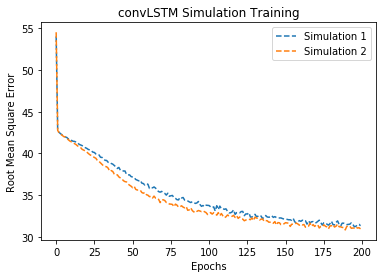

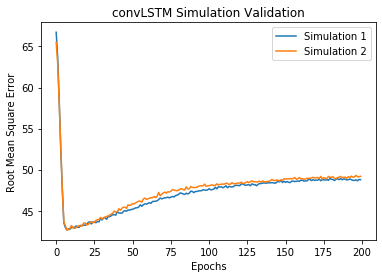

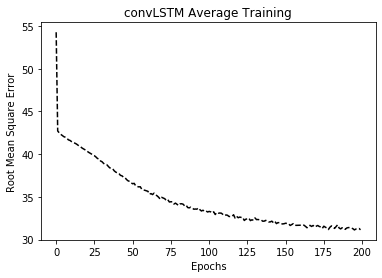

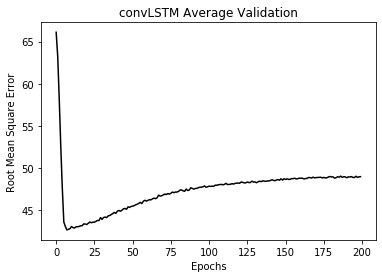

In [31]:
k = 2
n_simulations = 2
epochs = 200
batchsize = 64
sim_train = np.zeros((n_simulations, epochs))
sim_test = np.zeros((n_simulations, epochs))
simulation_list = []

for sim in range(n_simulations):
    model_sim_best, Ltrain, Ltest, lowest_val = CNN_LSTM(image_train, labels_train, epochs, k, batchsize, sim)
    
    # Testing model
    m_label = np.mean(image_test)
    s_label = np.std(image_test)
    X_model = norm(image_test, m_label, s_label)
    a,b,c = X_model.shape
    X_model = np.reshape(X_model, (a, 1, b, c, 1))
    R = model_sim_best.evaluate(X_model, labels_test, verbose = 0)
    simulation_list.append(R)
    
    if sim == 0:
        model_best = model_sim_best
        val_marker = lowest_val
    else:
        if lowest_val < val_marker:
            model_best = model_sim_best
            val_marker = lowest_val
    
    sim_train[sim] = np.mean(Ltrain, axis = 0)
    sim_test[sim] = np.mean(Ltest, axis = 0)
    
    plt.figure(1)
    plt.plot(range(epochs), sim_train[sim], '--', label = 'Simulation {}'.format(sim+1))
    plt.figure(2)
    plt.plot(range(epochs), sim_test[sim], label = 'Simulation {}'.format(sim+1))

    
plt.figure(3)    
plt.plot(range(epochs), np.mean(sim_train, axis = 0), 'k--')
plt.figure(4)    
plt.plot(range(epochs), np.mean(sim_test, axis = 0), 'k')

clear_output()

titles = ['convLSTM Simulation Training', 'convLSTM Simulation Validation','convLSTM Average Training', 'convLSTM Average Validation']
for i in range(4):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    if i == 0 or i == 1:     
        plt.legend()   
        
overfit = np.sqrt(simulation_list) - np.min(sim_train, axis = 1)        
train_min_mean = np.mean(np.min(sim_train, axis = 1))
train_min_std = np.std(np.min(sim_train, axis = 1))
test_min_mean = np.mean(np.min(sim_test, axis = 1))
test_min_std = np.std(np.min(sim_test, axis = 1))
print('Final Training Mean RMSE:',train_min_mean)
print('Final Training STD RMSE:',train_min_std)
print('Final Validation Mean RMSE:',test_min_mean)
print('Final Validation STD RMSE:',test_min_std)
print('The Final Mean RMSE', np.mean(np.sqrt(simulation_list)))
print('The Final STD RMSE', np.std(np.sqrt(simulation_list)))
print('Overfit Mean', np.mean(overfit))
print('Overfit STD', np.std(overfit))
#-----------------Saving model------------------
# serialize model to JSON
model_json = model_best.to_json()
with open("convLSTM_model_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_best.save_weights("convLSTM_model_best.h5")
print("Saved model to disk")

In [ ]:
def prune(model):
    epochs_prune = 1
    batch = 1000
    end_step = np.ceil(1.0 * len(image_train)/batch).astype(np.int32) * epochs_prune
    new_pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.25,
                                                       final_sparsity = 0.25,
                                                       begin_step = 0,
                                                       end_step = end_step,
                                                       frequency = 100)}

    new_pruned_model = sparsity.prune_low_magnitude(model, **new_pruning_params)
    new_pruned_model.compile(loss = tf.keras.losses.mean_squared_error, optimizer = 'adam', metrics=['mse'])
    callbacks = [sparsity.UpdatePruningStep()]
    new_pruned_model.fit(image_train, labels_train,
              batch_size = batch,
              epochs = epochs_prune,
              verbose = 1,
              callbacks = callbacks)
    #           validation_data = (x_val, y_val))

    clear_output()
    final_model = sparsity.strip_pruning(new_pruned_model)
    score = new_pruned_model.evaluate(image_test, labels_test, verbose = 0)
    print('initial test RMSE = {:.2f}'.format(np.mean(np.sqrt(simulation_list))))
    print('The final test RMSE on the model is {:.2f}'.format(np.sqrt(score[0])))
    
    return new_pruned_model

prune(model)

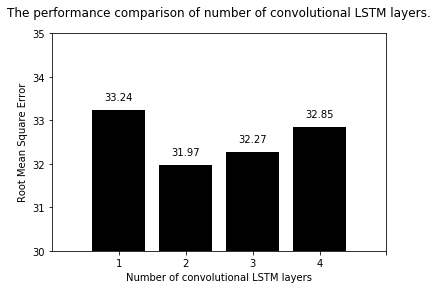

In [121]:
Y = [33.24, 31.97, 32.27, 32.85]
X = range(4) 
plt.bar(X,Y, color = 'black')
plt.ylim(30,35)
plt.ylabel('Root Mean Square Error')
plt.xlabel('Number of convolutional LSTM layers')
plt.xticks([0,1,2,3,4],[1,2,3,4])
plt.title('The performance comparison of number of convolutional LSTM layers.', y = 1.05)
plt.xlim(-1,4)
for x,y in zip(X,Y):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.savefig('lstm_performance.jpg')